<a href="https://colab.research.google.com/github/HansikaGunasekara/AI-Powered-Football-Commentator/blob/main/Predict_the_Winning_Football_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🏆⚽️ Predicting the Winning Football Team**

In [120]:
# imports
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,\
 StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

## 💾 **Data Manipulation**

In [6]:
PROJECT_ID = "fine-volt-479411-q4"  # Replace with your BigQuery Project ID
QUERY = """
SELECT
    *
FROM
    `fine-volt-479411-q4.English_Primier_League.*`
"""

# Authenticate to Google Cloud if running in Colab
from google.colab import auth
auth.authenticate_user()

# 1. Initialize the BigQuery client
client = bigquery.Client(project=PROJECT_ID)

# 2. Run the query and load results into a pandas DataFrame
# The to_dataframe() method handles the BigQuery Storage API for fast downloads
print("Executing BigQuery query and downloading data...")
combined_epl_data = client.query(QUERY).to_dataframe()

# 3. View the merged data
print(f"Data successfully loaded. Shape: {combined_epl_data.shape}")
combined_epl_data.head()

Executing BigQuery query and downloading data...
Data successfully loaded. Shape: (7640, 28)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR
0,E0,2008-08-24,Wigan,Chelsea,0,1,A,0,1,A,...,7,7,13,17,<NA>,<NA>,1,2,0,0
1,E0,2008-08-25,Portsmouth,Man United,0,1,A,0,1,A,...,4,3,11,11,<NA>,<NA>,2,2,0,0
2,E0,2008-08-30,Everton,Portsmouth,0,3,A,0,2,A,...,4,3,5,11,<NA>,<NA>,1,0,0,0
3,E0,2008-08-30,Hull,Wigan,0,5,A,0,2,A,...,7,3,18,12,<NA>,<NA>,1,0,0,0
4,E0,2008-08-31,Sunderland,Man City,0,3,A,0,1,A,...,3,3,20,11,<NA>,<NA>,4,2,0,0


In [6]:
# Save the dataset
#combined_epl_data.to_csv("combined_epl_data.csv", index=False)

## 🕵🏼‍♀️ **Feature Engineering**

In [7]:
# Sort the combine dataframe by date
combined_epl_data = combined_epl_data.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [8]:
df = combined_epl_data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]

## ✅ 1. HomeTeam_Last10Goals
Total goals scored by the home team in their previous 10 matches (no leakage).

## ✅ 2. AwayTeam_Last10Goals
Total goals scored by the away team in their previous 10 matches.

In [9]:
def add_last_10_goals_features(df):
    """
    Adds leak-free rolling goal features for each team based on their last 10 matches.
    Creates:
        - HomeTeam_Last10Goals
        - AwayTeam_Last10Goals

    Logic:
        - Convert to long format (one row per team per match)
        - Shift goals by 1 match so current match does NOT include itself
        - Compute rolling 10-match goal total
        - Merge back into original dataframe
    """

    df = df.sort_values('Date').reset_index(drop=True).copy()

    # Long format: team, opponent, goals scored
    home_df = df[['Date', 'HomeTeam', 'FTHG']].rename(
        columns={'HomeTeam': 'Team', 'FTHG': 'Goals'}
    )
    away_df = df[['Date', 'AwayTeam', 'FTAG']].rename(
        columns={'AwayTeam': 'Team', 'FTAG': 'Goals'}
    )

    long_df = pd.concat([home_df, away_df], ignore_index=True)

    # Sort by team & date
    long_df = long_df.sort_values(['Team', 'Date'])

    # Shift to remove leakage: current match should NOT include its own goals
    long_df['PastGoals'] = long_df.groupby('Team')['Goals'].shift(1)

    # Rolling sum of last 10 matches
    long_df['Last10Goals'] = (
        long_df.groupby('Team')['PastGoals']
        .rolling(10, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )

    # Split back into home/away for merging
    home_feat = long_df[['Date', 'Team', 'Last10Goals']]
    away_feat = long_df[['Date', 'Team', 'Last10Goals']]

    df = df.merge(
        home_feat,
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Last10Goals': 'HomeTeam_Last10Goals'}).drop(columns='Team')

    df = df.merge(
        away_feat,
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Last10Goals': 'AwayTeam_Last10Goals'}).drop(columns='Team')

    return df

df = add_last_10_goals_features(df)

## ✅ 3. HomeTeam_Last10GoalsConceded
Total goals conceded by the home team in their last 10 matches
(you can compute from FTAG/FTHG depending on home/away roles).

## ✅ 4. AwayTeam_Last10GoalsConceded
Total goals conceded by the away team in their last 10 matches.

In [11]:
def add_last10_goals_conceded(df):
    """
    Adds leak-free rolling goals-conceded features:
        - HomeTeam_Last10Conceded
        - AwayTeam_Last10Conceded

    Logic:
        1. Convert matches to long format (one row per team per match)
        2. Assign goals conceded depending on whether team played home or away
        3. SHIFT by 1 to avoid letting a match see its own goals (no leakage)
        4. Compute rolling(10).sum() per team
        5. Merge back into original dataframe
    """
    df = df.sort_values("Date").reset_index(drop=True).copy()

    # Long format: each match represented twice (once per team)
    home_df = df[['Date', 'HomeTeam', 'FTAG']] \
        .rename(columns={'HomeTeam': 'Team', 'FTAG': 'Conceded'})
    away_df = df[['Date', 'AwayTeam', 'FTHG']] \
        .rename(columns={'AwayTeam': 'Team', 'FTHG': 'Conceded'})

    long_df = pd.concat([home_df, away_df], ignore_index=True)

    # Sort for rolling computation
    long_df = long_df.sort_values(['Team', 'Date'])

    # SHIFT by 1 match to avoid leakage (current match cannot see its own goals conceded)
    long_df['PastConceded'] = long_df.groupby('Team')['Conceded'].shift(1)

    # Rolling 10-match goals conceded
    long_df['Last10Conceded'] = (
        long_df.groupby('Team')['PastConceded']
        .rolling(10, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )

    # Separate home and away for merging
    home_feat = long_df[['Date', 'Team', 'Last10Conceded']]
    away_feat = long_df[['Date', 'Team', 'Last10Conceded']]

    # Merge into main df
    df = df.merge(
        home_feat,
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Last10Conceded': 'HomeTeam_Last10GoalsConceded'}) \
     .drop(columns='Team')

    df = df.merge(
        away_feat,
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Last10Conceded': 'AwayTeam_Last10GoalsConceded'}) \
     .drop(columns='Team')

    return df

df = add_last10_goals_conceded(df)


## ✅ 5. HomeTeam_Form_Last5
A weighted form score over the last 5 matches:
Win = 3
Draw = 1
Loss = 0
Sum the previous 5 results.

## ✅ 6. AwayTeam_Form_Last5
Same as above but for the away team.

In [13]:
def add_form_score(df, window=5):
    """
    Adds leak-free rolling form features for both teams:
        - HomeTeam_Form_LastN
        - AwayTeam_Form_LastN

    Form scoring:
        Win  = 3
        Draw = 1
        Loss = 0

    Avoids leakage by:
        - Expanding matches to long format (one row per team)
        - Assigning form points per team per match
        - SHIFTING by 1 so current match does NOT include its own result
        - Rolling sum over last N matches
    """
    df = df.sort_values("Date").reset_index(drop=True).copy()

    # ----- Calculate form points for home and away teams -----
    def get_points(result, home=True):
        if result == 'H':
            return 3 if home else 0
        if result == 'A':
            return 3 if not home else 0
        return 1  # Draw for both teams

    df['HomePoints'] = df['FTR'].apply(lambda r: get_points(r, home=True))
    df['AwayPoints'] = df['FTR'].apply(lambda r: get_points(r, home=False))

    # ----- Long format: one row per team -----
    home_df = df[['Date', 'HomeTeam', 'HomePoints']] \
        .rename(columns={'HomeTeam': 'Team', 'HomePoints': 'Points'})
    away_df = df[['Date', 'AwayTeam', 'AwayPoints']] \
        .rename(columns={'AwayTeam': 'Team', 'AwayPoints': 'Points'})

    long_df = pd.concat([home_df, away_df], ignore_index=True)

    # Sort for rolling computation
    long_df = long_df.sort_values(['Team', 'Date'])

    # ----- Avoid data leakage (shift by 1 match) -----
    long_df['PastPoints'] = long_df.groupby('Team')['Points'].shift(1)

    # ----- Rolling form score -----
    long_df['Form_LastN'] = (
        long_df.groupby('Team')['PastPoints']
        .rolling(window, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )

    # Extract home and away form for merging
    home_form = long_df[['Date', 'Team', 'Form_LastN']]
    away_form = long_df[['Date', 'Team', 'Form_LastN']]

    # ----- Merge into original dataframe -----
    df = df.merge(
        home_form,
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Form_LastN': f'HomeTeam_Form_Last{window}'}) \
     .drop(columns='Team')

    df = df.merge(
        away_form,
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'Form_LastN': f'AwayTeam_Form_Last{window}'}) \
     .drop(columns='Team')

    # Remove temporary point columns
    df = df.drop(columns=['HomePoints', 'AwayPoints'])

    return df

df = add_form_score(df, window=5)

## ✅ 7. HomeTeam_AvgGoalsLast5
Average goals scored in the last 5 matches for the home team.
Often more stable than a 10-match total.

## ✅ 8. AwayTeam_AvgGoalsLast5
Average goals scored in the last 5 matches for the away team.

In [16]:
def add_avg_goals_last5(df):
    """
    Adds leak-free rolling average goals scored features:
        - HomeTeam_AvgGoalsLast5
        - AwayTeam_AvgGoalsLast5

    Method:
        1. Convert data to long format (one row per team per match).
        2. Assign goals scored for each team in each match.
        3. SHIFT by 1 so the current match does NOT include its own goals (avoids leakage).
        4. Compute rolling 5-match average.
        5. Merge results back into the original dataframe.
    """

    df = df.sort_values("Date").reset_index(drop=True).copy()

    # Long format: each match twice (home team row + away team row)
    home_df = df[['Date', 'HomeTeam', 'FTHG']] \
        .rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals'})
    away_df = df[['Date', 'AwayTeam', 'FTAG']] \
        .rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals'})

    long_df = pd.concat([home_df, away_df], ignore_index=True)

    # Sort for rolling calculations
    long_df = long_df.sort_values(['Team', 'Date'])

    # Avoid data leakage: shift goals by 1 match
    long_df['PastGoals'] = long_df.groupby('Team')['Goals'].shift(1)

    # Rolling 5-match average
    long_df['AvgGoalsLast5'] = (
        long_df.groupby('Team')['PastGoals']
        .rolling(5, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

    # Split for merge
    home_feat = long_df[['Date', 'Team', 'AvgGoalsLast5']]
    away_feat = long_df[['Date', 'Team', 'AvgGoalsLast5']]

    # Merge back into original df
    df = df.merge(
        home_feat,
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'AvgGoalsLast5': 'HomeTeam_AvgGoalsLast5'}) \
     .drop(columns='Team')

    df = df.merge(
        away_feat,
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'AvgGoalsLast5': 'AwayTeam_AvgGoalsLast5'}) \
     .drop(columns='Team')

    return df

df = add_avg_goals_last5(df)


## ✅ 9. HomeTeam_HomeAdvantage_Last5
Goals scored at home in the last 5 home matches only.
This isolates home-specific performance.

##✅ 10. AwayTeam_AwayAdvantage_Last5

> Add blockquote


Goals scored away in the last 5 away matches only.
Useful because some teams perform differently away.

In [18]:
def add_home_away_advantage_last5(df):
    """
    Creates two leak-free rolling home/away-specific features:
        - HomeTeam_HomeAdvantage_Last5 : Avg goals scored by the home team in its last 5 HOME matches only
        - AwayTeam_AwayAdvantage_Last5 : Avg goals scored by the away team in its last 5 AWAY matches only

    Method:
        1. Split matches into home-only and away-only datasets.
        2. For each team, compute goals scored (home goals for home matches / away goals for away matches).
        3. SHIFT by 1 so a team does NOT use the current match's goals (avoids leakage).
        4. Compute rolling average over last 5 HOME matches and last 5 AWAY matches separately.
        5. Merge into original dataframe.
    """
    import pandas as pd

    df = df.sort_values("Date").reset_index(drop=True).copy()

    # --------------------------
    #  HOME ADVANTAGE (Home matches only)
    # --------------------------
    home_only = df[['Date', 'HomeTeam', 'FTHG']] \
        .rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals'})

    home_only = home_only.sort_values(['Team', 'Date'])

    # Shift to avoid data leakage
    home_only['PastGoals'] = home_only.groupby('Team')['Goals'].shift(1)

    # Rolling average over last 5 home matches
    home_only['HomeAdv_Last5'] = (
        home_only.groupby('Team')['PastGoals']
        .rolling(5, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

    # --------------------------
    #  AWAY ADVANTAGE (Away matches only)
    # --------------------------
    away_only = df[['Date', 'AwayTeam', 'FTAG']] \
        .rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals'})

    away_only = away_only.sort_values(['Team', 'Date'])

    # Shift to avoid leakage
    away_only['PastGoals'] = away_only.groupby('Team')['Goals'].shift(1)

    # Rolling average over last 5 away matches
    away_only['AwayAdv_Last5'] = (
        away_only.groupby('Team')['PastGoals']
        .rolling(5, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

    # --------------------------
    # MERGE BACK INTO ORIGINAL DF
    # --------------------------

    # Merge home advantage
    df = df.merge(
        home_only[['Date', 'Team', 'HomeAdv_Last5']],
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'HomeAdv_Last5': 'HomeTeam_HomeAdvantage_Last5'}) \
     .drop(columns='Team')

    # Merge away advantage
    df = df.merge(
        away_only[['Date', 'Team', 'AwayAdv_Last5']],
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'AwayAdv_Last5': 'AwayTeam_AwayAdvantage_Last5'}) \
     .drop(columns='Team')

    return df

df = add_home_away_advantage_last5(df)
df.isna().sum()

,0
Div,0
Date,0
HomeTeam,0
AwayTeam,0
FTHG,0
FTAG,0
FTR,0
HomeTeam_Last10Goals,20
AwayTeam_Last10Goals,23
HomeTeam_Last10GoalsConceded,20


In [19]:
def add_days_since_last_match(df):
    """
    Adds leak-free 'days since last match' features for each team:
        - HomeTeam_DaysSinceLastMatch
        - AwayTeam_DaysSinceLastMatch

    Method:
        1. Sort by date.
        2. Long-format: one row per team per match.
        3. For each team, compute the difference in days between the current match
           and the previous match (shifted → avoids data leakage).
        4. Merge back into the main dataframe.
    """
    import pandas as pd

    df = df.sort_values("Date").reset_index(drop=True).copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # ----- LONG FORMAT -----
    home_df = df[['Date', 'HomeTeam']].rename(columns={'HomeTeam': 'Team'})
    away_df = df[['Date', 'AwayTeam']].rename(columns={'AwayTeam': 'Team'})

    long_df = pd.concat([home_df, away_df], ignore_index=True)

    # Sort for correct time-based processing
    long_df = long_df.sort_values(['Team', 'Date'])

    # ----- SHIFT TO AVOID DATA LEAKAGE -----
    long_df['PrevMatchDate'] = long_df.groupby('Team')['Date'].shift(1)

    # Days difference
    long_df['DaysSinceLast'] = (long_df['Date'] - long_df['PrevMatchDate']).dt.days

    # Split home/away for merging
    home_feat = long_df[['Date', 'Team', 'DaysSinceLast']]
    away_feat = long_df[['Date', 'Team', 'DaysSinceLast']]

    # ----- MERGE BACK -----
    df = df.merge(
        home_feat,
        left_on=['Date', 'HomeTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'DaysSinceLast': 'HomeTeam_DaysSinceLastMatch'}) \
     .drop(columns='Team')

    df = df.merge(
        away_feat,
        left_on=['Date', 'AwayTeam'],
        right_on=['Date', 'Team'],
        how='left'
    ).rename(columns={'DaysSinceLast': 'AwayTeam_DaysSinceLastMatch'}) \
     .drop(columns='Team')

    return df

df = add_days_since_last_match(df)

In [20]:
list(df)

['Div',
 'Date',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HomeTeam_Last10Goals',
 'AwayTeam_Last10Goals',
 'HomeTeam_Last10GoalsConceded',
 'AwayTeam_Last10GoalsConceded',
 'HomeTeam_Form_Last5',
 'AwayTeam_Form_Last5',
 'HomeTeam_AvgGoalsLast5',
 'AwayTeam_AvgGoalsLast5',
 'HomeTeam_AvgGoalsLast5',
 'AwayTeam_AvgGoalsLast5',
 'HomeTeam_HomeAdvantage_Last5',
 'AwayTeam_AwayAdvantage_Last5',
 'HomeTeam_HomeAdvantage_Last5',
 'AwayTeam_AwayAdvantage_Last5',
 'HomeTeam_DaysSinceLastMatch',
 'AwayTeam_DaysSinceLastMatch']

In [23]:
def ftr_to_bool(result):
    """
    Converts FTR to a boolean:
        H  -> True   (Home win)
        D/A -> False (Not home win)
    """
    return 1 if result == 'H' else 0

df['FTR_HomeWin'] = df['FTR'].apply(ftr_to_bool)

In [24]:
df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomeTeam_Last10Goals,AwayTeam_Last10Goals,HomeTeam_Last10GoalsConceded,...,AwayTeam_AvgGoalsLast5,HomeTeam_AvgGoalsLast5,AwayTeam_AvgGoalsLast5,HomeTeam_HomeAdvantage_Last5,AwayTeam_AwayAdvantage_Last5,HomeTeam_HomeAdvantage_Last5,AwayTeam_AwayAdvantage_Last5,HomeTeam_DaysSinceLastMatch,AwayTeam_DaysSinceLastMatch,FTR_HomeWin
0,E0,2001-08-18,Leeds,Southampton,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,E0,2001-08-18,Sunderland,Ipswich,1,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,E0,2001-08-18,Liverpool,West Ham,2,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,E0,2001-08-18,Charlton,Everton,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,E0,2001-08-18,Middlesbrough,Arsenal,0,4,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,E0,2022-05-22,Crystal Palace,Man United,1,0,H,12.0,13.0,8.0,...,1.0,1.2,1.0,1.0,0.4,1.0,0.4,3.0,15.0,1
7636,E0,2022-05-22,Leicester,Southampton,4,1,H,16.0,8.0,12.0,...,0.8,2.2,0.8,1.6,0.6,1.6,0.6,3.0,5.0,1
7637,E0,2022-05-22,Arsenal,Everton,5,1,H,13.0,13.0,16.0,...,1.6,1.4,1.6,1.6,1.0,1.6,1.0,6.0,3.0,1
7638,E0,2022-05-22,Liverpool,Wolves,3,1,H,20.0,13.0,5.0,...,0.8,1.6,0.8,2.0,0.6,2.0,0.6,5.0,7.0,1


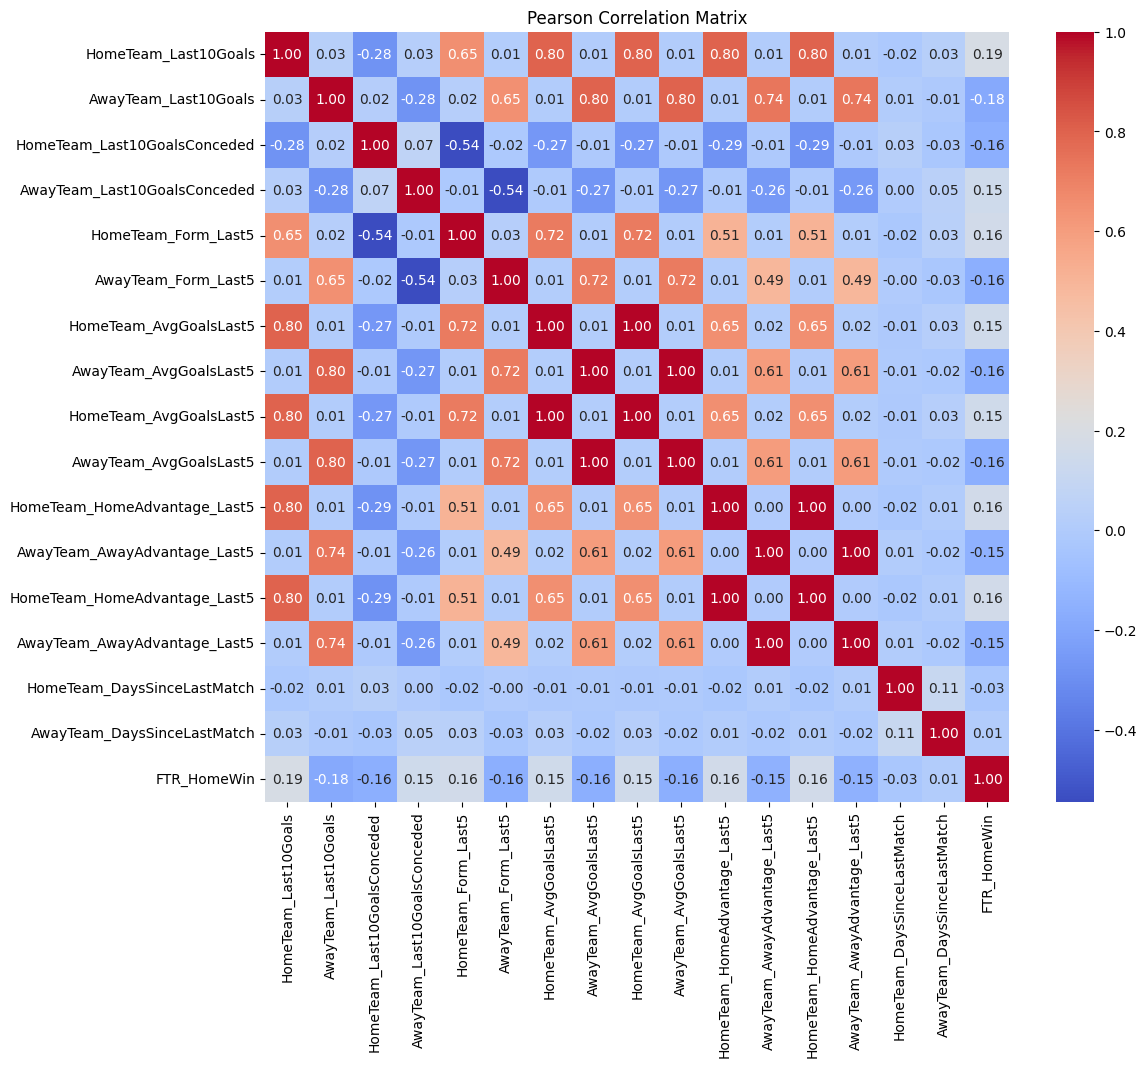

In [32]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')
numeric_df.drop(['FTHG', 'FTAG'], axis=1, inplace=True)

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()



## Win rate for the home team
Win Rate = (Number of Wins) / (Total Number of Matches)

In [36]:
n_matches = df.shape[0]
n_wins = df['FTR_HomeWin'].sum()
win_rate = n_wins / n_matches
print(f"Win Rate: {win_rate:.2%}")

Win Rate: 45.59%


## Split into train & test datasets

In [47]:
# Drop rows with missing values
df = df.dropna()

In [48]:
def train_test_split_by_date(df, train_start='2001-01-01', train_end='2016-12-31',
                             test_start='2017-01-01', test_end='2021-12-31'):
    """
    Splits a football dataset into training and test sets based on the Date column.

    Parameters:
        df (pd.DataFrame): Dataset with a 'Date' column.
        train_start (str): Start date for training data.
        train_end (str): End date for training data.
        test_start (str): Start date for test data.
        test_end (str): End date for test data.

    Returns:
        pd.DataFrame: Training dataframe
        pd.DataFrame: Test dataframe
    """
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Training data: 2001 to 2016
    train_df = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)].copy()

    # Test data: 2017 to 2021
    test_df = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)].copy()

    return train_df, test_df

train_df, test_df = train_test_split_by_date(df)

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Training set shape: (5826, 24)
Test set shape: (1549, 24)


/tmp/ipython-input-1687274694.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


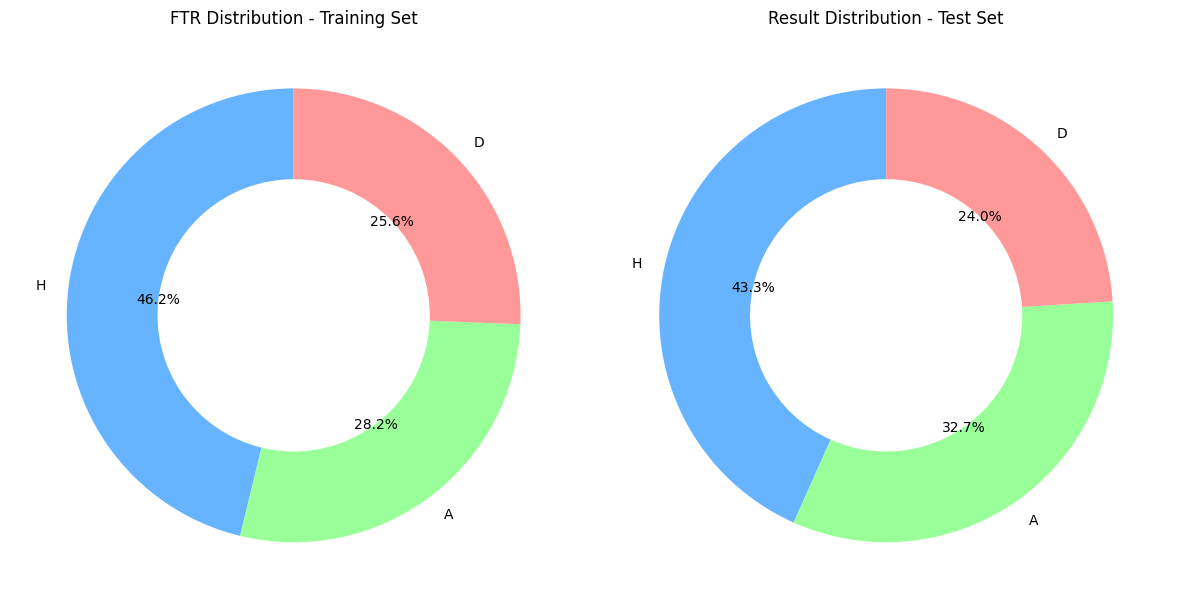

In [118]:
def plot_ftr_doughnut(train_df, test_df, target_col='FTR'):
    """
    Plots doughnut charts for FTR distribution in train and test datasets.

    Parameters:
        train_df (pd.DataFrame): Training dataframe
        test_df (pd.DataFrame): Test dataframe
        target_col (str): Column name of target (default 'FTR')
    """
    # Count values
    train_counts = train_df[target_col].value_counts()
    test_counts = test_df[target_col].value_counts()

    # Colors for H, D, A
    colors = ['#66b3ff','#99ff99','#ff9999']

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12,6))

    # --- Training set ---
    axes[0].pie(
        train_counts,
        labels=train_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'width':0.4}  # width <1 makes it a doughnut
    )
    axes[0].set_title("FTR Distribution - Training Set")

    # --- Test set ---
    axes[1].pie(
        test_counts,
        labels=test_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'width':0.4}
    )
    axes[1].set_title("Result Distribution - Test Set")

    plt.tight_layout()
    plt.show()

plot_ftr_doughnut(train_df, test_df)

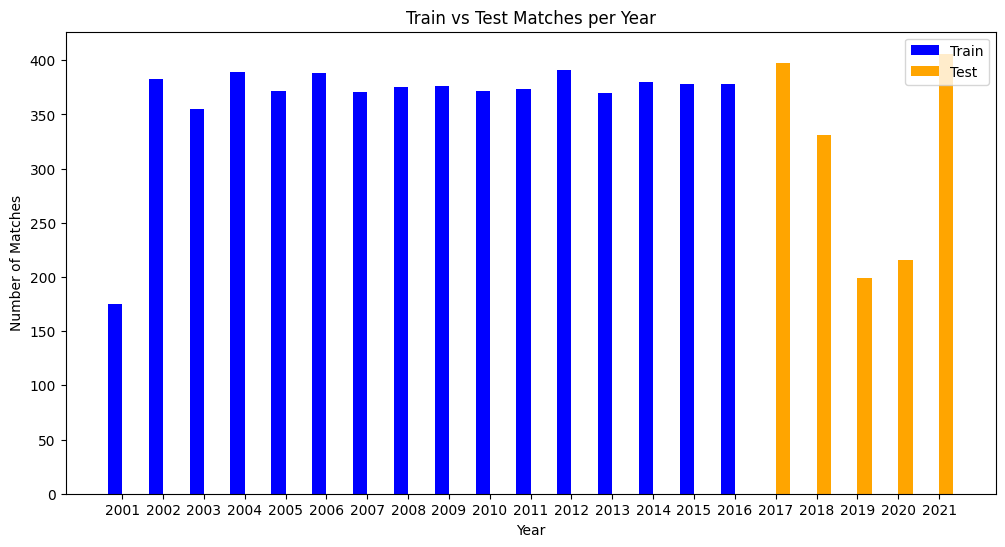

In [122]:
# Ensure 'Date' column is datetime
train_df['Year'] = pd.to_datetime(train_df['Date']).dt.year
test_df['Year'] = pd.to_datetime(test_df['Date']).dt.year

train_counts = train_df['Year'].value_counts().sort_index()
test_counts = test_df['Year'].value_counts().sort_index()
years = sorted(list(set(train_counts.index).union(test_counts.index)))

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, [train_counts.get(y,0) for y in years], width, label='Train', color='blue')
plt.bar(x + width/2, [test_counts.get(y,0) for y in years], width, label='Test', color='orange')
plt.xticks(x, years)
plt.xlabel("Year")
plt.ylabel("Number of Matches")
plt.title("Train vs Test Matches per Year")
plt.legend()
plt.show()


In [116]:
def prepare_ml_data(train_df, test_df, target_col='FTR_HomeWin', drop_cols=None):
    """
    Separates features and target for ML prediction.
    Also ensures unique column names in feature dataframes.

    Parameters:
        train_df (pd.DataFrame): Training dataframe
        test_df (pd.DataFrame): Test dataframe
        target_col (str): Name of the target column
        drop_cols (list or None): Columns to drop from features (like identifiers, teams, date)

    Returns:
        X_train, y_train, X_test, y_test
    """

    if drop_cols is None:
        drop_cols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']  # common non-numeric columns

    # Remove duplicate columns, keeping the first occurrence
    train_df = train_df.loc[:, ~train_df.columns.duplicated()]
    test_df = test_df.loc[:, ~test_df.columns.duplicated()]

    # Drop target and unwanted columns from features
    X_train = train_df.drop(columns=drop_cols + [target_col], errors='ignore')
    y_train = train_df[target_col]

    X_test = test_df.drop(columns=drop_cols + [target_col], errors='ignore')
    y_test = test_df[target_col]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_ml_data(train_df, test_df, target_col='FTR_HomeWin')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5826, 12)
y_train shape: (5826,)
X_test shape: (1549, 12)
y_test shape: (1549,)


## ML Model Predictions
### Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Axes: >

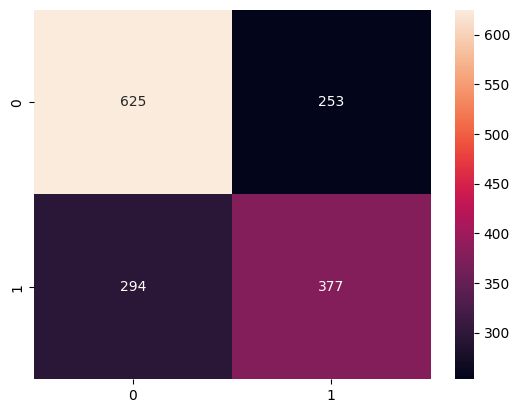

In [76]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [75]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       878
           1       0.59      0.53      0.56       671

    accuracy                           0.64      1549
   macro avg       0.63      0.63      0.63      1549
weighted avg       0.64      0.64      0.64      1549



## Random Forest Classifier

<Axes: >

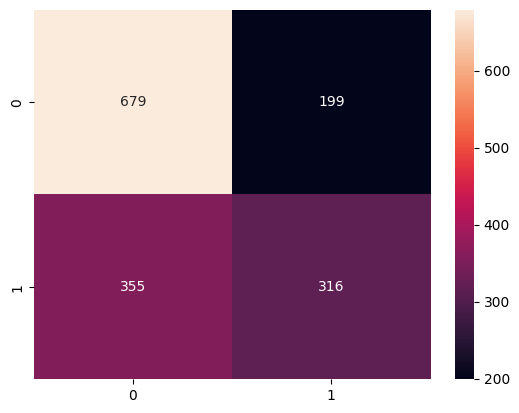

In [100]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [88]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       878
           1       0.61      0.47      0.53       671

    accuracy                           0.64      1549
   macro avg       0.64      0.62      0.62      1549
weighted avg       0.64      0.64      0.63      1549



## Neural Network Classifier

<Axes: >

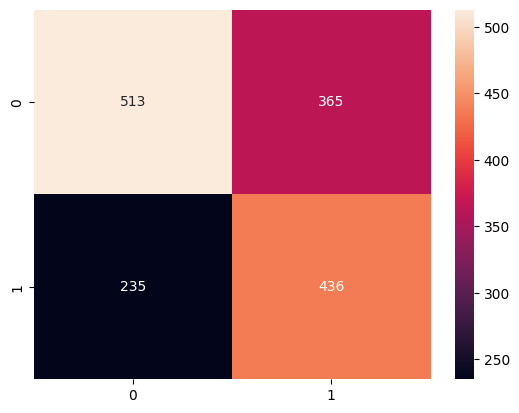

In [104]:
classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers with 64 and 32 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')

In [105]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       878
           1       0.54      0.65      0.59       671

    accuracy                           0.61      1549
   macro avg       0.62      0.62      0.61      1549
weighted avg       0.62      0.61      0.61      1549



## Ensemble Learner

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


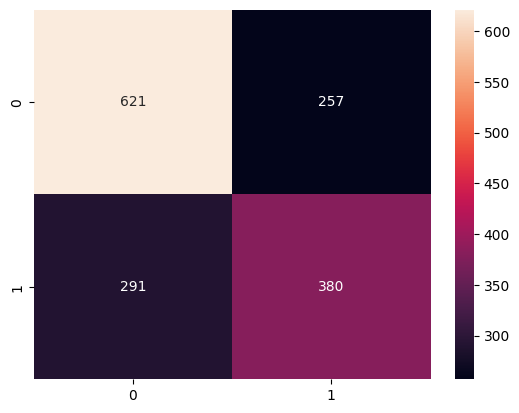

In [110]:
models = [
    ('lr', LogisticRegression(random_state = 0)),
    ('gbm_small', GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=42)),
    ('rf_small', RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('nb', GaussianNB()),
    ('mlp', MLPClassifier(
    hidden_layer_sizes=(64, 32),  # two hidden layers with 64 and 32 neurons
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42))
]

# ==========================
# Stacking (meta-learner)
# ==========================
stack = StackingClassifier(
    estimators=models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1,
    passthrough=True
)
stack.fit(X_train, y_train)
Y_pred = stack.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True,fmt='d')
y_prob = classifier.predict_proba(X_test)[:, 1]

In [111]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       878
           1       0.60      0.57      0.58       671

    accuracy                           0.65      1549
   macro avg       0.64      0.64      0.64      1549
weighted avg       0.64      0.65      0.64      1549



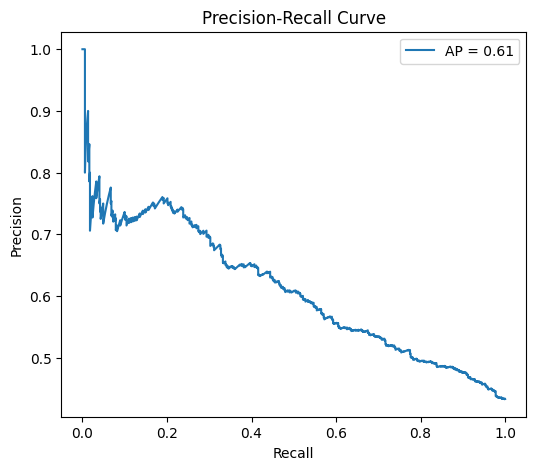

In [112]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()